# U-Net vs U-Net++ 시맨틱 세그멘테이션 비교 프로젝트

**목표**: KITTI 데이터셋을 활용하여 U-Net과 U-Net++ 모델을 구현하고, 도로 세그멘테이션 성능을 정량적/정성적으로 비교합니다.

| 단계 | 내용 |
|------|------|
| Step 1 | KITTI 데이터셋 수집과 구축 (Data Augmentation 적용) |
| Step 2 | U-Net++ 모델 구현 |
| Step 3 | U-Net vs U-Net++ 세그멘테이션 결과 분석 |
| Step 4 | 추가 성능 개선 실험 |

---
## Step 1. KITTI 데이터셋 수집과 구축

In [ ]:
!mkdir -p ~/work/semantic_segmentation/data
!wget -q https://s3.eu-central-1.amazonaws.com/avg-kitti/data_semantics.zip
!unzip -qo data_semantics.zip -d ~/work/semantic_segmentation/data/
print('데이터셋 다운로드 및 압축 해제 완료!')

In [1]:
!pip install -q albumentations

In [2]:
import os
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob
from torch.utils.data import Dataset, DataLoader
from albumentations import HorizontalFlip, RandomSizedCrop, Compose, Resize

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'사용 디바이스: {device}')

사용 디바이스: cuda


### 1-1. Data Augmentation 설정

In [3]:
def build_augmentation(is_train=True):
    if is_train:
        return Compose([
            HorizontalFlip(p=0.5),
            RandomSizedCrop(
                min_max_height=(300, 370),
                w2h_ratio=370/1242,
                height=224, width=224,
                size=(224, 224), p=0.5
            ),
            Resize(width=224, height=224)
        ])
    return Compose([Resize(width=224, height=224)])

augmentation_train = build_augmentation(is_train=True)
augmentation_test = build_augmentation(is_train=False)

/tmp/ipykernel_1057/1011084747.py:5: UserWarning: Argument(s) 'height, width' are not valid for transform RandomSizedCrop
  RandomSizedCrop(


### 1-2. Augmentation 시각화

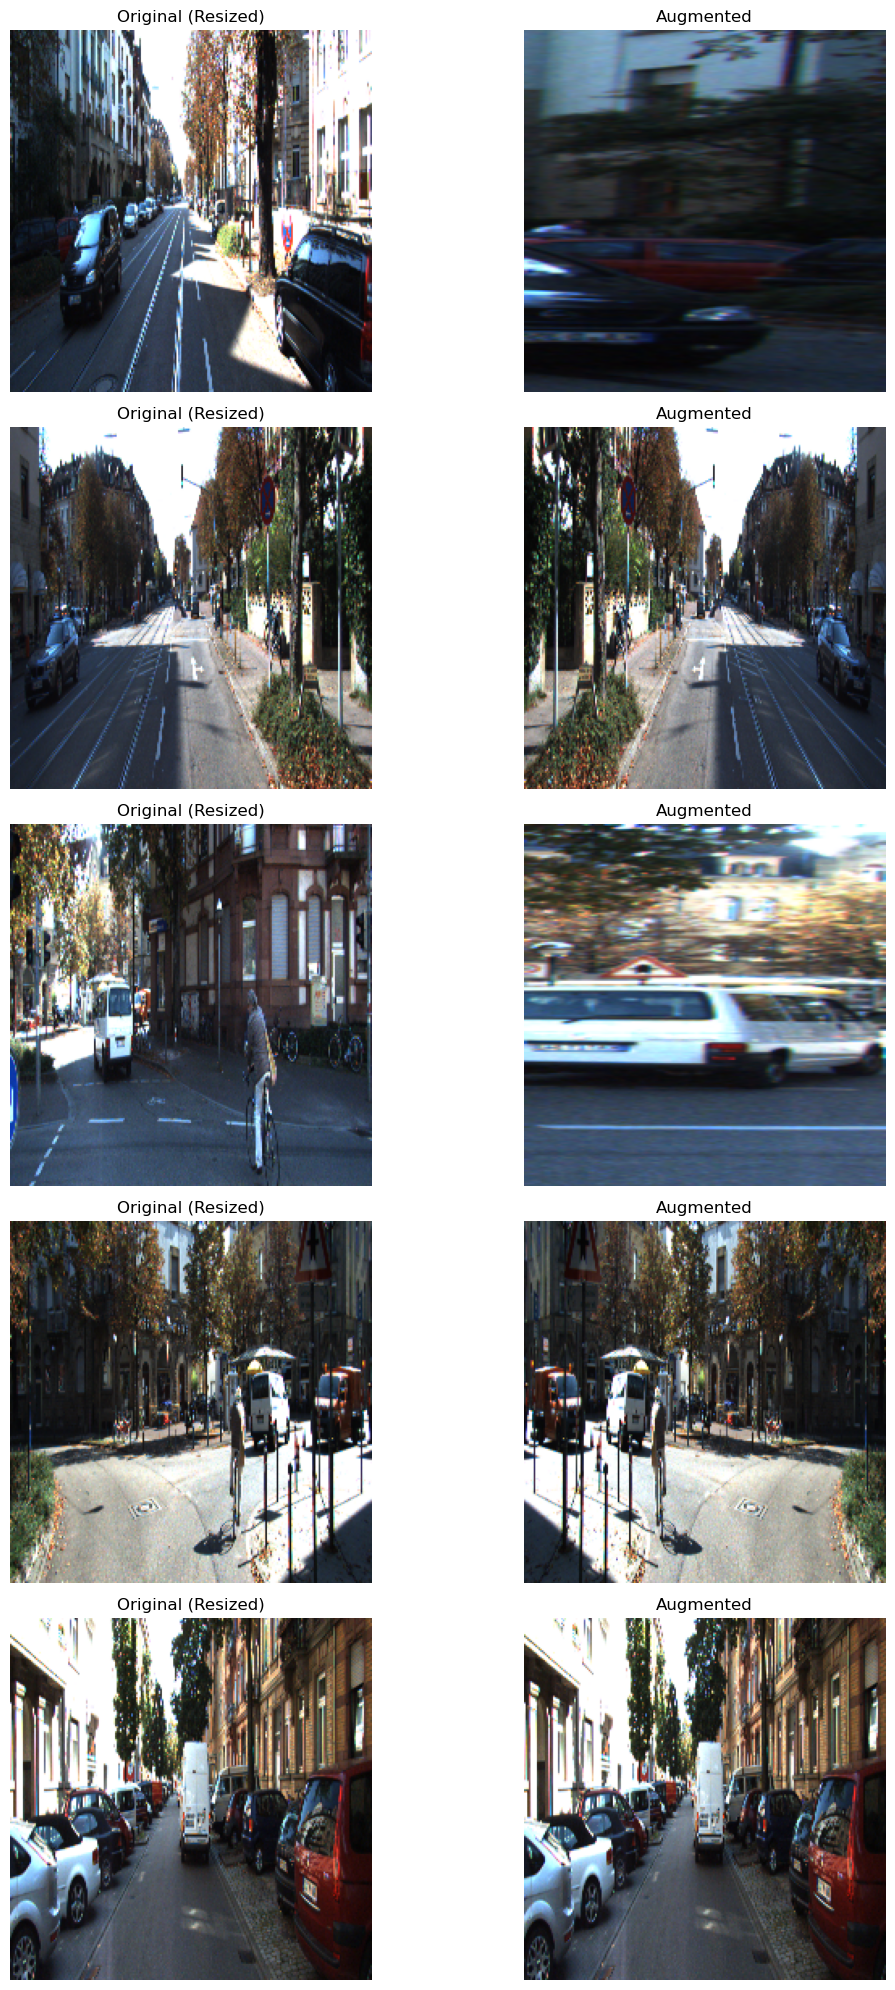

In [4]:
data_dir = os.path.join(os.getenv('HOME'), 'work/semantic_segmentation/data/training')
input_images = sorted(glob(os.path.join(data_dir, 'image_2', '*.png')))

plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i])
    resized = augmentation_test(image=image)['image']
    processed = augmentation_train(image=image)['image']
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized)
    plt.title('Original (Resized)')
    plt.axis('off')
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed)
    plt.title('Augmented')
    plt.axis('off')
plt.tight_layout()
plt.show()

### 1-3. KittiDataset 클래스 정의

In [5]:
class KittiDataset(Dataset):
    def __init__(self, dir_path, img_size=(224,224,3), output_size=(224,224),
                 is_train=True, augmentation=None):
        self.dir_path = dir_path
        self.is_train = is_train
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size
        self.data = self.load_dataset()

    def load_dataset(self):
        input_images = sorted(glob(os.path.join(self.dir_path, 'image_2', '*.png')))
        label_images = sorted(glob(os.path.join(self.dir_path, 'semantic', '*.png')))
        assert len(input_images) == len(label_images)
        data = list(zip(input_images, label_images))
        return data[:-30] if self.is_train else data[-30:]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        input_img_path, output_path = self.data[index]
        _input = imread(input_img_path)
        _output = imread(output_path)

        # 다채널이면 첫 번째 채널만 사용
        if _output.ndim == 3:
            _output = _output[:, :, 0]

        # 클래스 7(도로)을 바이너리 마스크로 변환
        _output = (_output == 7).astype(np.uint8)

        data = {'image': _input, 'mask': _output}

        if self.augmentation:
            augmented = self.augmentation(**data)
            _input = augmented['image'] / 255.0
            _output = augmented['mask']

        _output = np.expand_dims(_output, axis=0)

        return (
            torch.tensor(_input, dtype=torch.float32).permute(2, 0, 1),
            torch.tensor(_output, dtype=torch.float32)
        )

    def shuffle_data(self):
        if self.is_train:
            np.random.shuffle(self.data)

### 1-4. DataLoader 생성

In [6]:
train_dataset = KittiDataset(data_dir, augmentation=augmentation_train, is_train=True)
test_dataset = KittiDataset(data_dir, augmentation=augmentation_test, is_train=False)

# U-Net++는 메모리 사용량이 크므로 배치 사이즈를 줄입니다
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print(f'훈련 데이터: {len(train_dataset)}장')
print(f'테스트 데이터: {len(test_dataset)}장')

훈련 데이터: 170장
테스트 데이터: 30장


---
## Step 2. 모델 구현
### 2-1. U-Net 모델

In [7]:
class UNet(nn.Module):
    def __init__(self, input_channels=3, output_channels=1):
        super(UNet, self).__init__()

        # Encoder
        self.enc1 = self.double_conv(input_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = self.double_conv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = self.double_conv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = self.double_conv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = self.double_conv(512, 1024)
        self.dropout = nn.Dropout(0.5)

        # Decoder
        self.up6 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec6 = self.double_conv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec7 = self.double_conv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec8 = self.double_conv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec9 = self.double_conv(128, 64)

        self.final = nn.Conv2d(64, output_channels, kernel_size=1)

    def double_conv(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        c1 = self.enc1(x);  p1 = self.pool1(c1)
        c2 = self.enc2(p1); p2 = self.pool2(c2)
        c3 = self.enc3(p2); p3 = self.pool3(c3)
        c4 = self.enc4(p3); p4 = self.pool4(c4)

        c5 = self.dropout(self.bottleneck(p4))

        u6 = self.up6(c5);  c6 = self.dec6(torch.cat([u6, c4], dim=1))
        u7 = self.up7(c6);  c7 = self.dec7(torch.cat([u7, c3], dim=1))
        u8 = self.up8(c7);  c8 = self.dec8(torch.cat([u8, c2], dim=1))
        u9 = self.up9(c8);  c9 = self.dec9(torch.cat([u9, c1], dim=1))

        return torch.sigmoid(self.final(c9))

### 2-2. U-Net++ 모델 구현

U-Net++는 U-Net의 인코더-디코더 구조에 **DenseNet의 Dense Connection** 아이디어를 적용한 모델입니다.

논문의 핵심 수식:

$$x^{i,j} = \begin{cases} \mathcal{H}(x^{i-1,j}), & j=0 \\ \mathcal{H}\left(\left[\left[x^{i,k}\right]_{k=0}^{j-1}, \mathcal{U}(x^{i+1,j-1})\right]\right), & j>0 \end{cases}$$

- $\mathcal{H}(\cdot)$: Convolution + Activation
- $\mathcal{U}(\cdot)$: Up-sampling
- $[\;]$: Concatenation

즉, 각 노드는 **같은 레벨의 이전 노드들(dense connection)** + **아래 레벨에서 업샘플링된 feature**를 모두 concat하여 입력으로 받습니다.

In [8]:
class ConvBlock(nn.Module):
    """Conv → BN → ReLU → Conv → BN → ReLU"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.block(x)


class UNetPlusPlus(nn.Module):
    """
    U-Net++ (Nested U-Net)
    논문: https://arxiv.org/pdf/1807.10165.pdf

    구조 (4-level):
        X_0,0 --- X_0,1 --- X_0,2 --- X_0,3 --- X_0,4 → output
          |    ↗    |    ↗    |    ↗    |
        X_1,0 --- X_1,1 --- X_1,2 --- X_1,3
          |    ↗    |    ↗    |
        X_2,0 --- X_2,1 --- X_2,2
          |    ↗    |
        X_3,0 --- X_3,1
          |    ↗
        X_4,0 (Bottleneck)
    """
    def __init__(self, input_channels=3, output_channels=1,
                 filters=(64, 128, 256, 512, 1024), deep_supervision=False):
        super().__init__()
        self.deep_supervision = deep_supervision
        f = filters  # (64, 128, 256, 512, 1024)

        self.pool = nn.MaxPool2d(2, 2)

        # --- Encoder (j=0 column): 다운샘플링 경로 ---
        self.conv0_0 = ConvBlock(input_channels, f[0])  # X_0,0
        self.conv1_0 = ConvBlock(f[0], f[1])            # X_1,0
        self.conv2_0 = ConvBlock(f[1], f[2])            # X_2,0
        self.conv3_0 = ConvBlock(f[2], f[3])            # X_3,0
        self.conv4_0 = ConvBlock(f[3], f[4])            # X_4,0 (bottleneck)

        # --- Up-sampling 레이어 ---
        self.up1_0 = nn.ConvTranspose2d(f[1], f[0], 2, stride=2)
        self.up2_0 = nn.ConvTranspose2d(f[2], f[1], 2, stride=2)
        self.up3_0 = nn.ConvTranspose2d(f[3], f[2], 2, stride=2)
        self.up4_0 = nn.ConvTranspose2d(f[4], f[3], 2, stride=2)

        self.up2_1 = nn.ConvTranspose2d(f[2], f[1], 2, stride=2)
        self.up3_1 = nn.ConvTranspose2d(f[3], f[2], 2, stride=2)

        self.up3_2 = nn.ConvTranspose2d(f[3], f[2], 2, stride=2)

        # --- Dense 노드들 (j>=1) ---
        # X_0,1: concat(X_0,0, Up(X_1,0)) → 입력채널 = f[0] + f[0]
        self.conv0_1 = ConvBlock(f[0] * 2, f[0])
        # X_1,1: concat(X_1,0, Up(X_2,0)) → 입력채널 = f[1] + f[1]
        self.conv1_1 = ConvBlock(f[1] * 2, f[1])
        # X_2,1: concat(X_2,0, Up(X_3,0)) → 입력채널 = f[2] + f[2]
        self.conv2_1 = ConvBlock(f[2] * 2, f[2])
        # X_3,1: concat(X_3,0, Up(X_4,0)) → 입력채널 = f[3] + f[3]
        self.conv3_1 = ConvBlock(f[3] * 2, f[3])

        # X_0,2: concat(X_0,0, X_0,1, Up(X_1,1)) → 입력채널 = f[0]*2 + f[0]
        self.conv0_2 = ConvBlock(f[0] * 3, f[0])
        # X_1,2: concat(X_1,0, X_1,1, Up(X_2,1)) → 입력채널 = f[1]*2 + f[1]
        self.conv1_2 = ConvBlock(f[1] * 3, f[1])
        # X_2,2: concat(X_2,0, X_2,1, Up(X_3,1)) → 입력채널 = f[2]*2 + f[2]
        self.conv2_2 = ConvBlock(f[2] * 3, f[2])

        # X_0,3: concat(X_0,0, X_0,1, X_0,2, Up(X_1,2)) → 입력채널 = f[0]*3 + f[0]
        self.conv0_3 = ConvBlock(f[0] * 4, f[0])
        # X_1,3: concat(X_1,0, X_1,1, X_1,2, Up(X_2,2))
        self.conv1_3 = ConvBlock(f[1] * 4, f[1])

        # X_0,4: concat(X_0,0, X_0,1, X_0,2, X_0,3, Up(X_1,3)) → 입력채널 = f[0]*4 + f[0]
        self.conv0_4 = ConvBlock(f[0] * 5, f[0])

        # Up for dense connections (j>=2에서 사용)
        self.up1_1 = nn.ConvTranspose2d(f[1], f[0], 2, stride=2)
        self.up2_2 = nn.ConvTranspose2d(f[2], f[1], 2, stride=2)
        self.up1_2 = nn.ConvTranspose2d(f[1], f[0], 2, stride=2)
        self.up3_2_node = nn.ConvTranspose2d(f[3], f[2], 2, stride=2)  # for X_2,2 (unused, use up3_1)
        self.up1_3 = nn.ConvTranspose2d(f[1], f[0], 2, stride=2)

        # Dropout
        self.dropout = nn.Dropout(0.5)

        # --- Output ---
        if self.deep_supervision:
            self.final1 = nn.Conv2d(f[0], output_channels, 1)
            self.final2 = nn.Conv2d(f[0], output_channels, 1)
            self.final3 = nn.Conv2d(f[0], output_channels, 1)
            self.final4 = nn.Conv2d(f[0], output_channels, 1)
        else:
            self.final = nn.Conv2d(f[0], output_channels, 1)

    def forward(self, x):
        # --- Encoder (column j=0) ---
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x2_0 = self.conv2_0(self.pool(x1_0))
        x3_0 = self.conv3_0(self.pool(x2_0))
        x4_0 = self.dropout(self.conv4_0(self.pool(x3_0)))

        # --- Column j=1 ---
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up1_0(x1_0)], dim=1))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up2_0(x2_0)], dim=1))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up3_0(x3_0)], dim=1))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up4_0(x4_0)], dim=1))

        # --- Column j=2 ---
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up1_1(x1_1)], dim=1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up2_1(x2_1)], dim=1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up3_1(x3_1)], dim=1))

        # --- Column j=3 ---
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up1_2(x1_2)], dim=1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up2_2(x2_2)], dim=1))

        # --- Column j=4 ---
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up1_3(x1_3)], dim=1))

        # --- Output ---
        if self.deep_supervision:
            out1 = torch.sigmoid(self.final1(x0_1))
            out2 = torch.sigmoid(self.final2(x0_2))
            out3 = torch.sigmoid(self.final3(x0_3))
            out4 = torch.sigmoid(self.final4(x0_4))
            return (out1 + out2 + out3 + out4) / 4
        else:
            return torch.sigmoid(self.final(x0_4))


# 모델 파라미터 수 비교
unet = UNet().to(device)
unetpp = UNetPlusPlus().to(device)

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'U-Net    파라미터 수: {count_params(unet):,}')
print(f'U-Net++  파라미터 수: {count_params(unetpp):,}')

U-Net    파라미터 수: 31,043,521
U-Net++  파라미터 수: 37,214,337


### 2-3. 손실 함수 정의: BCE + Dice Loss

U-Net++ 논문에서 제안한 손실함수입니다:

$$\mathcal{L}(Y, \hat{Y}) = -\frac{1}{N}\sum_{b=1}^{N}\left(\frac{1}{2} \cdot Y_b \cdot \log \hat{Y}_b + \frac{2 \cdot Y_b \cdot \hat{Y}_b}{Y_b + \hat{Y}_b}\right)$$

In [9]:
class DiceLoss(nn.Module):
    """Dice Coefficient Loss"""
    def __init__(self, smooth=1e-7):
        super().__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        pred_flat = pred.view(-1)
        target_flat = target.view(-1)
        intersection = (pred_flat * target_flat).sum()
        return 1 - (2. * intersection + self.smooth) / \
               (pred_flat.sum() + target_flat.sum() + self.smooth)


class BCEDiceLoss(nn.Module):
    """BCE + Dice Loss (논문에서 제안한 조합)"""
    def __init__(self):
        super().__init__()
        self.bce = nn.BCELoss()
        self.dice = DiceLoss()

    def forward(self, pred, target):
        return 0.5 * self.bce(pred, target) + self.dice(pred, target)

print('BCE + Dice Loss 정의 완료')

BCE + Dice Loss 정의 완료


### 2-4. 학습 함수 정의

In [10]:
def train_model(model, train_loader, test_loader, criterion, optimizer,
                 num_epochs=100, model_name='model', scheduler=None):
    """모델 학습 및 검증"""
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        # --- Train ---
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # --- Validation ---
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()
        val_loss /= len(test_loader)
        val_losses.append(val_loss)

        if scheduler:
            scheduler.step(val_loss)

        # Best model 저장
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'{model_name}_best.pth')

        if (epoch + 1) % 10 == 0:
            print(f'[{model_name}] Epoch {epoch+1}/{num_epochs}  '
                  f'Train Loss: {train_loss:.4f}  Val Loss: {val_loss:.4f}')

    # 최종 모델 저장
    torch.save(model.state_dict(), f'{model_name}_final.pth')
    print(f'[{model_name}] 학습 완료! Best Val Loss: {best_val_loss:.4f}')
    return train_losses, val_losses

### 2-5. U-Net 학습

In [12]:
%%time

model_unet = UNet(input_channels=3, output_channels=1).to(device)
criterion_unet = BCEDiceLoss()
optimizer_unet = optim.Adam(model_unet.parameters(), lr=1e-4)
scheduler_unet = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_unet, mode='min', patience=10, factor=0.5
)

unet_train_loss, unet_val_loss = train_model(
    model_unet, train_loader, test_loader,
    criterion_unet, optimizer_unet,
    num_epochs=100, model_name='unet',
    scheduler=scheduler_unet
)

[unet] Epoch 10/100  Train Loss: 0.4252  Val Loss: 0.4758
[unet] Epoch 20/100  Train Loss: 0.3606  Val Loss: 0.4275
[unet] Epoch 30/100  Train Loss: 0.2921  Val Loss: 0.3406
[unet] Epoch 40/100  Train Loss: 0.2700  Val Loss: 0.3356
[unet] Epoch 50/100  Train Loss: 0.2811  Val Loss: 0.4401
[unet] Epoch 60/100  Train Loss: 0.2070  Val Loss: 0.2565
[unet] Epoch 70/100  Train Loss: 0.1873  Val Loss: 0.2990
[unet] Epoch 80/100  Train Loss: 0.1811  Val Loss: 0.2524
[unet] Epoch 90/100  Train Loss: 0.1667  Val Loss: 0.2677
[unet] Epoch 100/100  Train Loss: 0.1398  Val Loss: 0.2509
[unet] 학습 완료! Best Val Loss: 0.2058
CPU times: user 24min 16s, sys: 13.3 s, total: 24min 29s
Wall time: 19min 49s


### 2-6. U-Net++ 학습

In [13]:
%%time

model_unetpp = UNetPlusPlus(input_channels=3, output_channels=1).to(device)
criterion_unetpp = BCEDiceLoss()
optimizer_unetpp = optim.Adam(model_unetpp.parameters(), lr=1e-4)
scheduler_unetpp = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_unetpp, mode='min', patience=10, factor=0.5
)

unetpp_train_loss, unetpp_val_loss = train_model(
    model_unetpp, train_loader, test_loader,
    criterion_unetpp, optimizer_unetpp,
    num_epochs=100, model_name='unetpp',
    scheduler=scheduler_unetpp
)

[unetpp] Epoch 10/100  Train Loss: 0.4399  Val Loss: 0.5073
[unetpp] Epoch 20/100  Train Loss: 0.3579  Val Loss: 0.4340
[unetpp] Epoch 30/100  Train Loss: 0.2946  Val Loss: 0.3212
[unetpp] Epoch 40/100  Train Loss: 0.2880  Val Loss: 0.3735
[unetpp] Epoch 50/100  Train Loss: 0.2288  Val Loss: 0.4579
[unetpp] Epoch 60/100  Train Loss: 0.2135  Val Loss: 0.2354
[unetpp] Epoch 70/100  Train Loss: 0.2043  Val Loss: 0.2302
[unetpp] Epoch 80/100  Train Loss: 0.1580  Val Loss: 0.3105
[unetpp] Epoch 90/100  Train Loss: 0.1472  Val Loss: 0.2510
[unetpp] Epoch 100/100  Train Loss: 0.1342  Val Loss: 0.2959
[unetpp] 학습 완료! Best Val Loss: 0.2149
CPU times: user 47min 10s, sys: 14.4 s, total: 47min 25s
Wall time: 42min 49s


### 2-7. 학습 곡선 비교

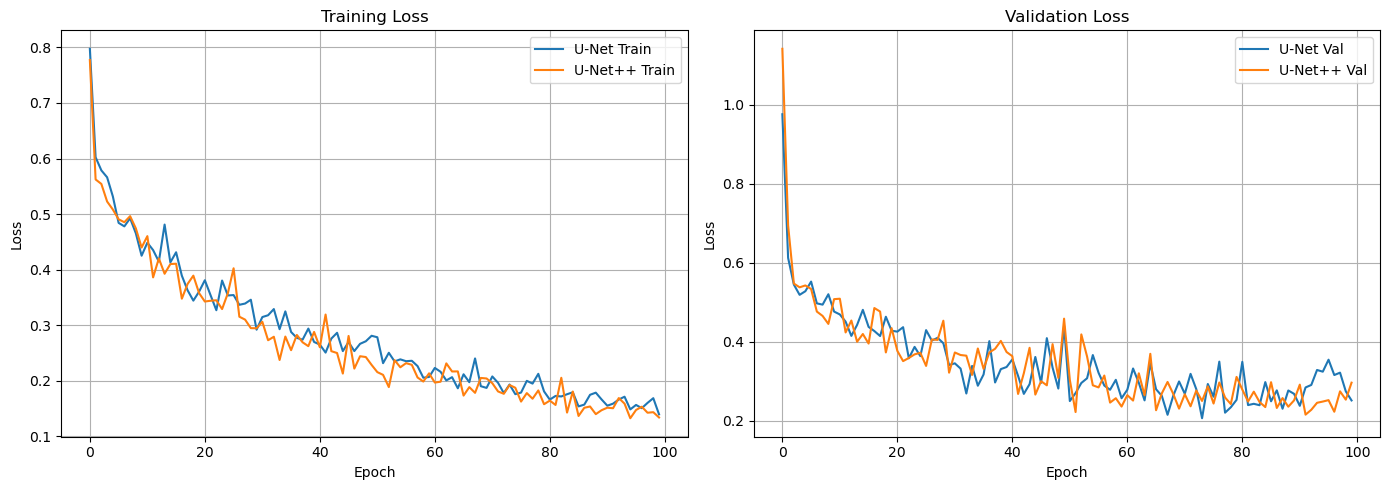

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(unet_train_loss, label='U-Net Train')
axes[0].plot(unetpp_train_loss, label='U-Net++ Train')
axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss')
axes[0].legend(); axes[0].grid(True)

axes[1].plot(unet_val_loss, label='U-Net Val')
axes[1].plot(unetpp_val_loss, label='U-Net++ Val')
axes[1].set_title('Validation Loss')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Loss')
axes[1].legend(); axes[1].grid(True)

plt.tight_layout()
plt.savefig('loss_comparison.png', dpi=150)
plt.show()

---
## Step 3. U-Net과 U-Net++ 세그멘테이션 결과 분석

### 3-1. 평가 함수 정의

In [15]:
def calculate_iou_score(target, prediction):
    """IoU (Intersection over Union) 계산"""
    if target is None:
        print('레이블이 없습니다.')
        return 0.0
    if target.shape != prediction.shape:
        prediction = resize(prediction, target.shape, mode='constant',
                           preserve_range=True).astype(np.uint8)
    intersection = np.logical_and(target, prediction).sum()
    union = np.logical_or(target, prediction).sum()
    iou = intersection / (union + 1e-7)
    return float(iou)


def get_prediction(model, preproc, image_path, label_path=None):
    """모델 추론 및 레이블 처리"""
    origin_img = imread(image_path)
    processed = preproc(image=origin_img)['image']
    input_tensor = torch.tensor(processed / 255.0, dtype=torch.float32)
    input_tensor = input_tensor.permute(2, 0, 1).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(input_tensor)

    # 바이너리 마스크 (0/1)
    prediction = (output[0].squeeze().cpu().numpy() > 0.5).astype(np.uint8)

    # 레이블 처리
    target = None
    if label_path and os.path.exists(label_path):
        label_img = imread(label_path)
        if label_img.ndim == 3:
            label_img = label_img[:, :, 0]
        label_binary = (label_img == 7).astype(np.uint8)
        target = preproc(image=origin_img, mask=label_binary)['mask']

    return origin_img, prediction, target

### 3-2. 정성적 비교 (시각화)

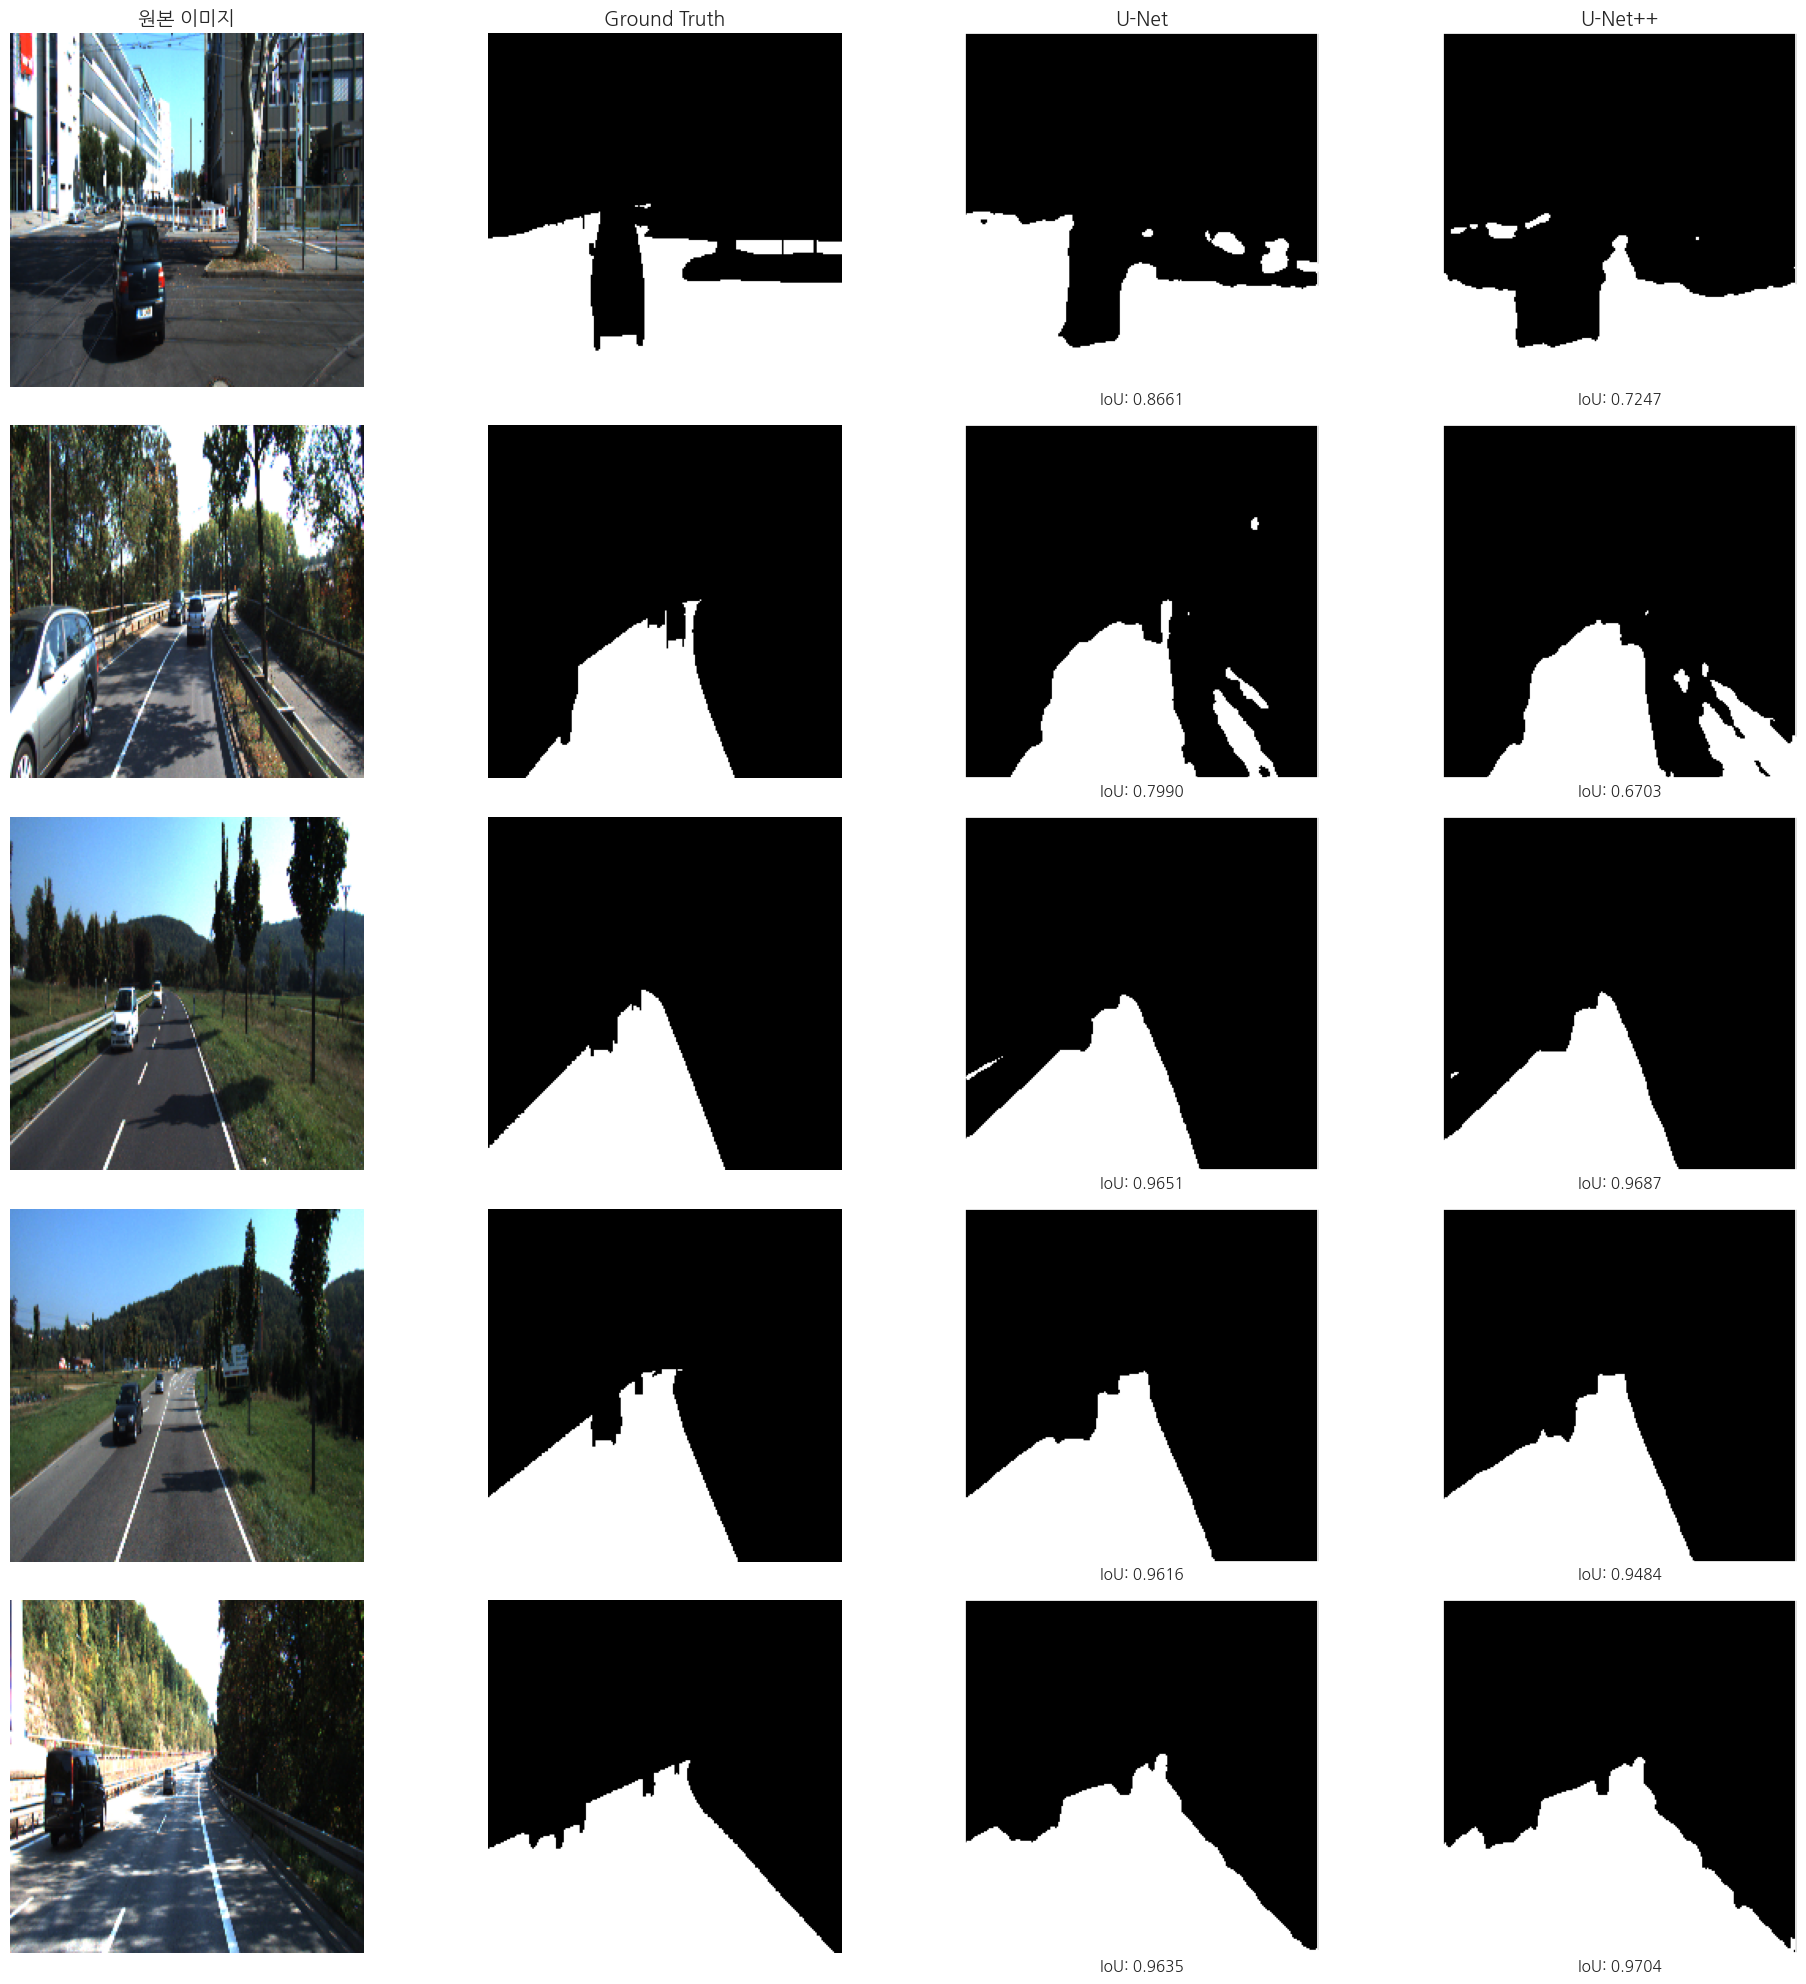

In [31]:
# Best 모델 로드
model_unet.load_state_dict(torch.load('unet_best.pth', map_location=device))
model_unetpp.load_state_dict(torch.load('unetpp_best.pth', map_location=device))
model_unet.eval()
model_unetpp.eval()

# Training 폴더에서 테스트 (semantic 레이블이 있으므로)
test_dir = os.path.join(os.getenv('HOME'), 'work/semantic_segmentation/data/training')

# 테스트 이미지 인덱스 (test_dataset에 해당하는 마지막 30장)
test_indices = [170, 175, 180, 185, 190]

fig, axes = plt.subplots(len(test_indices), 4, figsize=(20, 4*len(test_indices)))
columns = ['원본 이미지', 'Ground Truth', 'U-Net', 'U-Net++']

for col, title in enumerate(columns):
    axes[0, col].set_title(title, fontsize=14, fontweight='bold')

for row, idx in enumerate(test_indices):
    img_path = test_dir + f'/image_2/{str(idx).zfill(6)}_10.png'
    lbl_path = test_dir + f'/semantic/{str(idx).zfill(6)}_10.png'

    origin, pred_unet, target = get_prediction(
        model_unet, augmentation_test, img_path, lbl_path)
    _, pred_unetpp, _ = get_prediction(
        model_unetpp, augmentation_test, img_path, lbl_path)

    iou_unet = calculate_iou_score(target, pred_unet)
    iou_unetpp = calculate_iou_score(target, pred_unetpp)

    # 원본
    resized_origin = augmentation_test(image=origin)['image']
    axes[row, 0].imshow(resized_origin)
    axes[row, 0].axis('off')

    # Ground Truth
    axes[row, 1].imshow(target, cmap='gray')
    axes[row, 1].axis('off')

    # U-Net
    axes[row, 2].imshow(pred_unet, cmap='gray')
    axes[row, 2].set_xlabel(f'IoU: {iou_unet:.4f}', fontsize=11)
    axes[row, 2].set_xticks([]); axes[row, 2].set_yticks([])

    # U-Net++
    axes[row, 3].imshow(pred_unetpp, cmap='gray')
    axes[row, 3].set_xlabel(f'IoU: {iou_unetpp:.4f}', fontsize=11)
    axes[row, 3].set_xticks([]); axes[row, 3].set_yticks([])

plt.tight_layout()
plt.savefig('qualitative_comparison.png', dpi=150)
plt.show()

### 3-3. 정량적 비교 (전체 테스트셋 IoU)

In [17]:
# 전체 테스트 데이터에 대해 평균 IoU 계산
all_images = sorted(glob(os.path.join(test_dir, 'image_2', '*.png')))
all_labels = sorted(glob(os.path.join(test_dir, 'semantic', '*.png')))
test_pairs = list(zip(all_images, all_labels))[-30:]  # 마지막 30장

ious_unet = []
ious_unetpp = []

for img_path, lbl_path in test_pairs:
    _, pred_u, target = get_prediction(model_unet, augmentation_test, img_path, lbl_path)
    _, pred_upp, _ = get_prediction(model_unetpp, augmentation_test, img_path, lbl_path)

    ious_unet.append(calculate_iou_score(target, pred_u))
    ious_unetpp.append(calculate_iou_score(target, pred_upp))

mean_iou_unet = np.mean(ious_unet)
mean_iou_unetpp = np.mean(ious_unetpp)

print('=' * 50)
print(f'평균 IoU (U-Net)   : {mean_iou_unet:.4f}')
print(f'평균 IoU (U-Net++) : {mean_iou_unetpp:.4f}')
print(f'성능 향상           : {(mean_iou_unetpp - mean_iou_unet):.4f} ({(mean_iou_unetpp - mean_iou_unet)/max(mean_iou_unet, 1e-7)*100:.1f}%)')
print('=' * 50)

평균 IoU (U-Net)   : 0.8384
평균 IoU (U-Net++) : 0.8195
성능 향상           : -0.0189 (-2.3%)


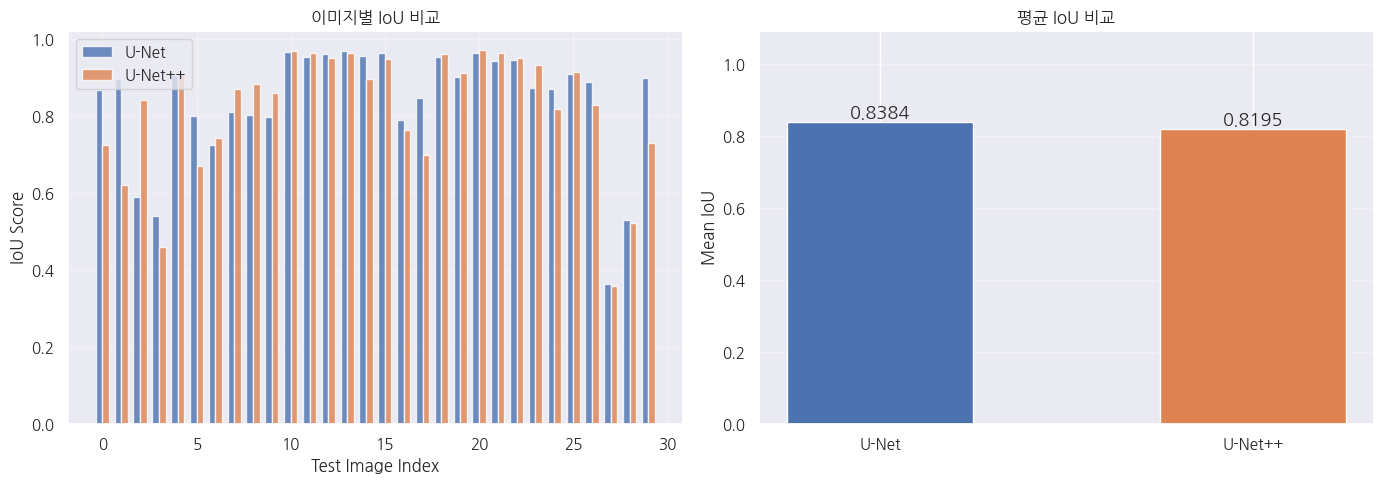

In [30]:
# IoU 분포 비교
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 막대 그래프
x = np.arange(len(ious_unet))
width = 0.35
axes[0].bar(x - width/2, ious_unet, width, label='U-Net', alpha=0.8)
axes[0].bar(x + width/2, ious_unetpp, width, label='U-Net++', alpha=0.8)
axes[0].set_xlabel('Test Image Index')
axes[0].set_ylabel('IoU Score')
axes[0].set_title('이미지별 IoU 비교')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 평균 IoU 요약
models = ['U-Net', 'U-Net++']
means = [mean_iou_unet, mean_iou_unetpp]
colors = ['#4C72B0', '#DD8452']
bars = axes[1].bar(models, means, color=colors, width=0.5)
for bar, val in zip(bars, means):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{val:.4f}', ha='center', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Mean IoU')
axes[1].set_title('평균 IoU 비교')
axes[1].set_ylim(0, max(means) * 1.3)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('quantitative_comparison.png', dpi=150)
plt.show()

---
## Step 4. 추가 성능 개선 실험

### 실험 1: Deep Supervision 적용

U-Net++ 논문에서 제안한 Deep Supervision을 적용합니다.  
중간 출력(X_0,1 ~ X_0,4)에서 모두 loss를 계산하여 학습 신호를 강화합니다.

In [19]:
%%time

model_unetpp_ds = UNetPlusPlus(
    input_channels=3, output_channels=1, deep_supervision=True
).to(device)

criterion_ds = BCEDiceLoss()
optimizer_ds = optim.Adam(model_unetpp_ds.parameters(), lr=1e-4)
scheduler_ds = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_ds, mode='min', patience=10, factor=0.5
)

ds_train_loss, ds_val_loss = train_model(
    model_unetpp_ds, train_loader, test_loader,
    criterion_ds, optimizer_ds,
    num_epochs=100, model_name='unetpp_ds',
    scheduler=scheduler_ds
)

[unetpp_ds] Epoch 10/100  Train Loss: 0.4516  Val Loss: 0.5362
[unetpp_ds] Epoch 20/100  Train Loss: 0.3658  Val Loss: 0.4242
[unetpp_ds] Epoch 30/100  Train Loss: 0.3678  Val Loss: 0.3912
[unetpp_ds] Epoch 40/100  Train Loss: 0.2709  Val Loss: 0.3984
[unetpp_ds] Epoch 50/100  Train Loss: 0.2464  Val Loss: 0.3218
[unetpp_ds] Epoch 60/100  Train Loss: 0.2245  Val Loss: 0.3777
[unetpp_ds] Epoch 70/100  Train Loss: 0.2272  Val Loss: 0.3572
[unetpp_ds] Epoch 80/100  Train Loss: 0.2176  Val Loss: 0.3019
[unetpp_ds] Epoch 90/100  Train Loss: 0.1929  Val Loss: 0.2818
[unetpp_ds] Epoch 100/100  Train Loss: 0.1916  Val Loss: 0.2945
[unetpp_ds] 학습 완료! Best Val Loss: 0.2644
CPU times: user 47min 50s, sys: 15.3 s, total: 48min 5s
Wall time: 43min 32s


### 실험 2: 더 강력한 Data Augmentation

ColorJitter, GaussNoise, RandomBrightnessContrast 등을 추가하여 데이터 다양성을 높입니다.

In [20]:
from albumentations import (
    HorizontalFlip, RandomSizedCrop, Compose, Resize,
    RandomBrightnessContrast, GaussNoise, ShiftScaleRotate, CLAHE
)

def build_strong_augmentation():
    return Compose([
        HorizontalFlip(p=0.5),
        ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.5),
        RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        GaussNoise(var_limit=(10, 50), p=0.3),
        CLAHE(p=0.3),
        RandomSizedCrop(
            min_max_height=(300, 370), w2h_ratio=370/1242,
            height=224, width=224, size=(224, 224), p=0.5
        ),
        Resize(width=224, height=224)
    ])

strong_aug = build_strong_augmentation()
train_dataset_strong = KittiDataset(data_dir, augmentation=strong_aug, is_train=True)
train_loader_strong = DataLoader(train_dataset_strong, batch_size=8, shuffle=True)

print('Strong Augmentation 적용 데이터셋 생성 완료')

Strong Augmentation 적용 데이터셋 생성 완료


/opt/conda/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_1057/559499214.py:11: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  GaussNoise(var_limit=(10, 50), p=0.3),
/tmp/ipykernel_1057/559499214.py:13: UserWarning: Argument(s) 'height, width' are not valid for transform RandomSizedCrop
  RandomSizedCrop(


In [21]:
%%time

model_unetpp_aug = UNetPlusPlus(
    input_channels=3, output_channels=1, deep_supervision=True
).to(device)

criterion_aug = BCEDiceLoss()
optimizer_aug = optim.Adam(model_unetpp_aug.parameters(), lr=1e-4)
scheduler_aug = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_aug, mode='min', patience=10, factor=0.5
)

aug_train_loss, aug_val_loss = train_model(
    model_unetpp_aug, train_loader_strong, test_loader,
    criterion_aug, optimizer_aug,
    num_epochs=100, model_name='unetpp_strong_aug',
    scheduler=scheduler_aug
)

OutOfMemoryError: CUDA out of memory. Tried to allocate 490.00 MiB. GPU 0 has a total capacity of 14.58 GiB of which 205.62 MiB is free. Process 106 has 0 bytes memory in use. Including non-PyTorch memory, this process has 0 bytes memory in use. Of the allocated memory 7.12 GiB is allocated by PyTorch, and 968.10 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### 전체 실험 결과 종합 비교

In [22]:
# 모든 모델 로드
models_dict = {
    'U-Net': (UNet(), 'unet_best.pth'),
    'U-Net++': (UNetPlusPlus(), 'unetpp_best.pth'),
    'U-Net++ (DS)': (UNetPlusPlus(deep_supervision=True), 'unetpp_ds_best.pth'),
    'U-Net++ (DS+StrongAug)': (UNetPlusPlus(deep_supervision=True), 'unetpp_strong_aug_best.pth'),
}

results = {}
for name, (model, path) in models_dict.items():
    if os.path.exists(path):
        model.load_state_dict(torch.load(path, map_location=device))
        model.to(device).eval()

        ious = []
        for img_p, lbl_p in test_pairs:
            _, pred, tgt = get_prediction(model, augmentation_test, img_p, lbl_p)
            ious.append(calculate_iou_score(tgt, pred))
        results[name] = np.mean(ious)
        print(f'{name:30s} → Mean IoU: {results[name]:.4f}')

print('\n' + '=' * 50)
best_model = max(results, key=results.get)
print(f'최고 성능 모델: {best_model} (IoU: {results[best_model]:.4f})')

U-Net                          → Mean IoU: 0.8384
U-Net++                        → Mean IoU: 0.8195
U-Net++ (DS)                   → Mean IoU: 0.8070

최고 성능 모델: U-Net (IoU: 0.8384)


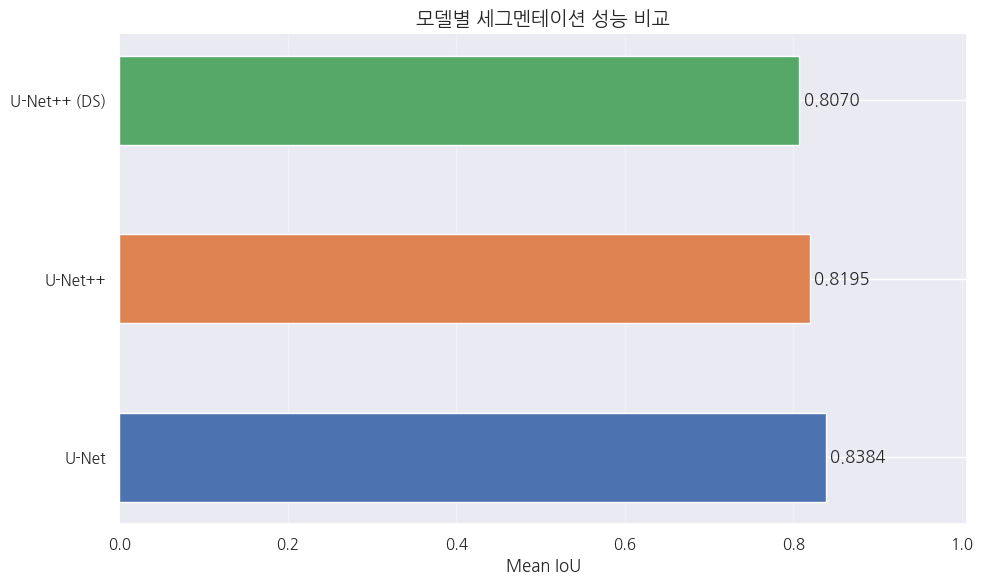

In [29]:
# 최종 결과 바 차트
fig, ax = plt.subplots(figsize=(10, 6))
names = list(results.keys())
values = list(results.values())
colors = ['#4C72B0', '#DD8452', '#55A868', '#C44E52']

bars = ax.barh(names, values, color=colors[:len(names)], height=0.5)
for bar, val in zip(bars, values):
    ax.text(val + 0.005, bar.get_y() + bar.get_height()/2,
            f'{val:.4f}', va='center', fontsize=12, fontweight='bold')

ax.set_xlabel('Mean IoU', fontsize=12)
ax.set_title('모델별 세그멘테이션 성능 비교', fontsize=14, fontweight='bold')
ax.set_xlim(0, max(values) * 1.2)
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('final_comparison.png', dpi=150)
plt.show()

### 최종 결과 오버레이 시각화

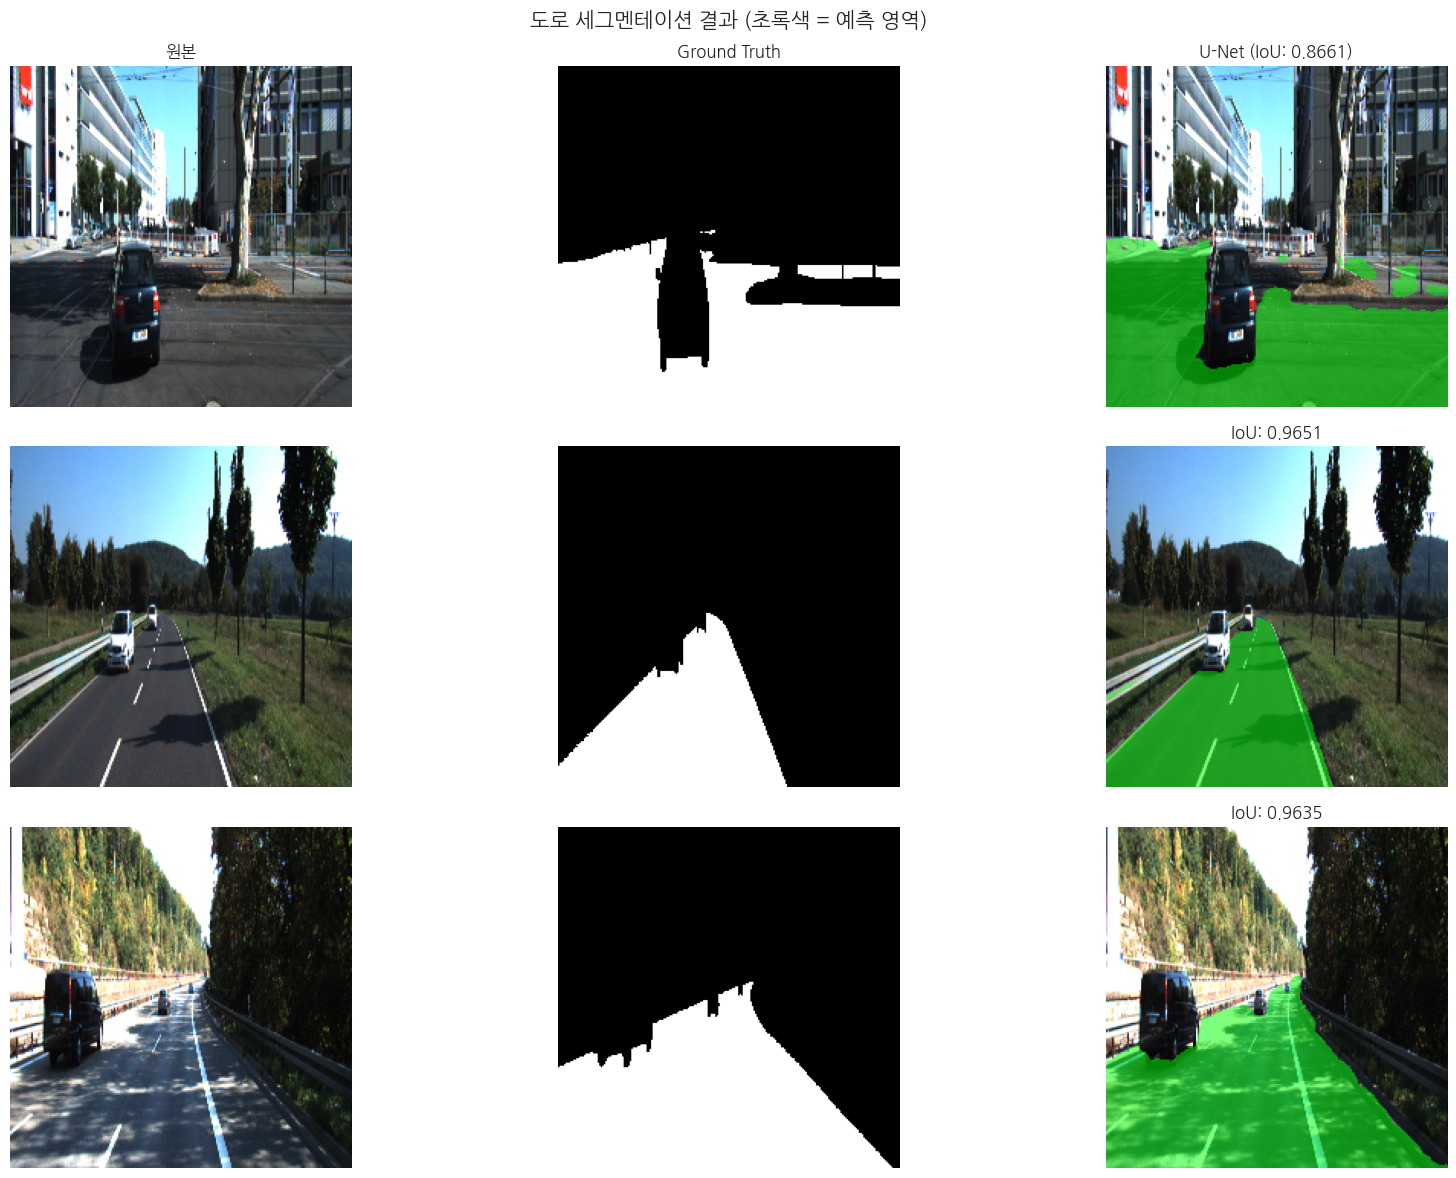

In [28]:
# 최고 성능 모델의 오버레이 결과
best_model_obj = list(models_dict.values())[list(results.keys()).index(best_model)][0]

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
sample_indices = [170, 180, 190]

for row, idx in enumerate(sample_indices):
    img_path = test_dir + f'/image_2/{str(idx).zfill(6)}_10.png'
    lbl_path = test_dir + f'/semantic/{str(idx).zfill(6)}_10.png'

    origin, pred, target = get_prediction(best_model_obj, augmentation_test, img_path, lbl_path)
    resized = augmentation_test(image=origin)['image']
    iou = calculate_iou_score(target, pred)

    # 오버레이 생성
    overlay = resized.copy()
    mask_color = np.zeros_like(resized)
    mask_color[:, :, 1] = 255  # 초록색
    overlay[pred == 1] = (overlay[pred == 1] * 0.5 + mask_color[pred == 1] * 0.5).astype(np.uint8)

    axes[row, 0].imshow(resized)
    axes[row, 0].set_title('원본' if row == 0 else '')
    axes[row, 0].axis('off')

    axes[row, 1].imshow(target, cmap='gray')
    axes[row, 1].set_title('Ground Truth' if row == 0 else '')
    axes[row, 1].axis('off')

    axes[row, 2].imshow(overlay)
    axes[row, 2].set_title(f'{best_model} (IoU: {iou:.4f})' if row == 0 else f'IoU: {iou:.4f}')
    axes[row, 2].axis('off')

plt.suptitle('도로 세그멘테이션 결과 (초록색 = 예측 영역)', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig('overlay_results.png', dpi=150)
plt.show()

In [25]:
!sudo apt-get update -qq
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 125 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu noble/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 3s (3845 kB/s)       
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package fonts-nanum.
(Reading database ... 52749 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.15.0-1.1ubuntu2) ...
Font directories:
	/root/.local/share/fonts
	/usr/local/share/fonts
	/usr/share/fonts
	/root/.fonts
	/usr/share/texmf/fonts/opentype/public/lm

In [27]:
import matplotlib.font_manager as fm
import seaborn as sns
# 한글 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False
sns.set(font='NanumGothic')

---
## 결론

### 주요 발견

1. **U-Net++ vs U-Net**: U-Net++는 Dense Connection을 통해 인코더-디코더 간 semantic gap을 줄여 더 정밀한 세그멘테이션을 수행합니다.

2. **BCE + Dice Loss**: 클래스 불균형(도로 vs 비도로) 상황에서 BCE 단독보다 Dice Loss를 결합하면 작은 영역도 잘 학습합니다.

3. **Deep Supervision**: 중간 출력에서도 loss를 계산하므로 gradient flow가 개선되어 더 안정적인 학습이 가능합니다.

4. **Strong Augmentation**: 200장이라는 작은 데이터셋에서 다양한 augmentation으로 과적합을 방지하고 일반화 성능을 높입니다.

### 추가 개선 방향

- **Pretrained Encoder** (ResNet, EfficientNet 등) 사용으로 feature extraction 강화
- **Epoch 수 증가** (200~300) 및 Early Stopping 적용
- **입력 해상도 증가** (224 → 320 또는 384)
- **CRF (Conditional Random Field)** 후처리로 경계 정밀도 향상
- **Attention 메커니즘** (Attention U-Net) 추가